## Cross verification of the paper : Third Quantization, Prosen, Thomas, arXiv:0801.1257v3

In [1]:
# General imports
import numpy as np
import qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import DensityMatrix, partial_trace
# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# [Reference]: https://docs.quantum.ibm.com/guides/build-noise-models
# https://docs.quantum.ibm.com/guides/simulate-with-qiskit-aer

from qiskit_aer import AerSimulator

from qiskit_aer.primitives import SamplerV2 as Sampler
#from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import StatevectorSampler
# sampler = StatevectorSampler()
sampler = Sampler()


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# YOUR_API_TOKEN = "a44932650c6324c729fbd156e2808cff2dc96cc78fdaf3058a5e3583edfadad4acf73471140788f0efa7ed71a98f1e13069af52fe115e4e0e2bb868ab0be5d70"
# QiskitRuntimeService.save_account(channel="ibm_quantum", token= YOUR_API_TOKEN, overwrite = True)
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")
# noise_model = NoiseModel.from_backend(backend)

In [3]:
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix, kron
from numpy import trace

# Ansatz

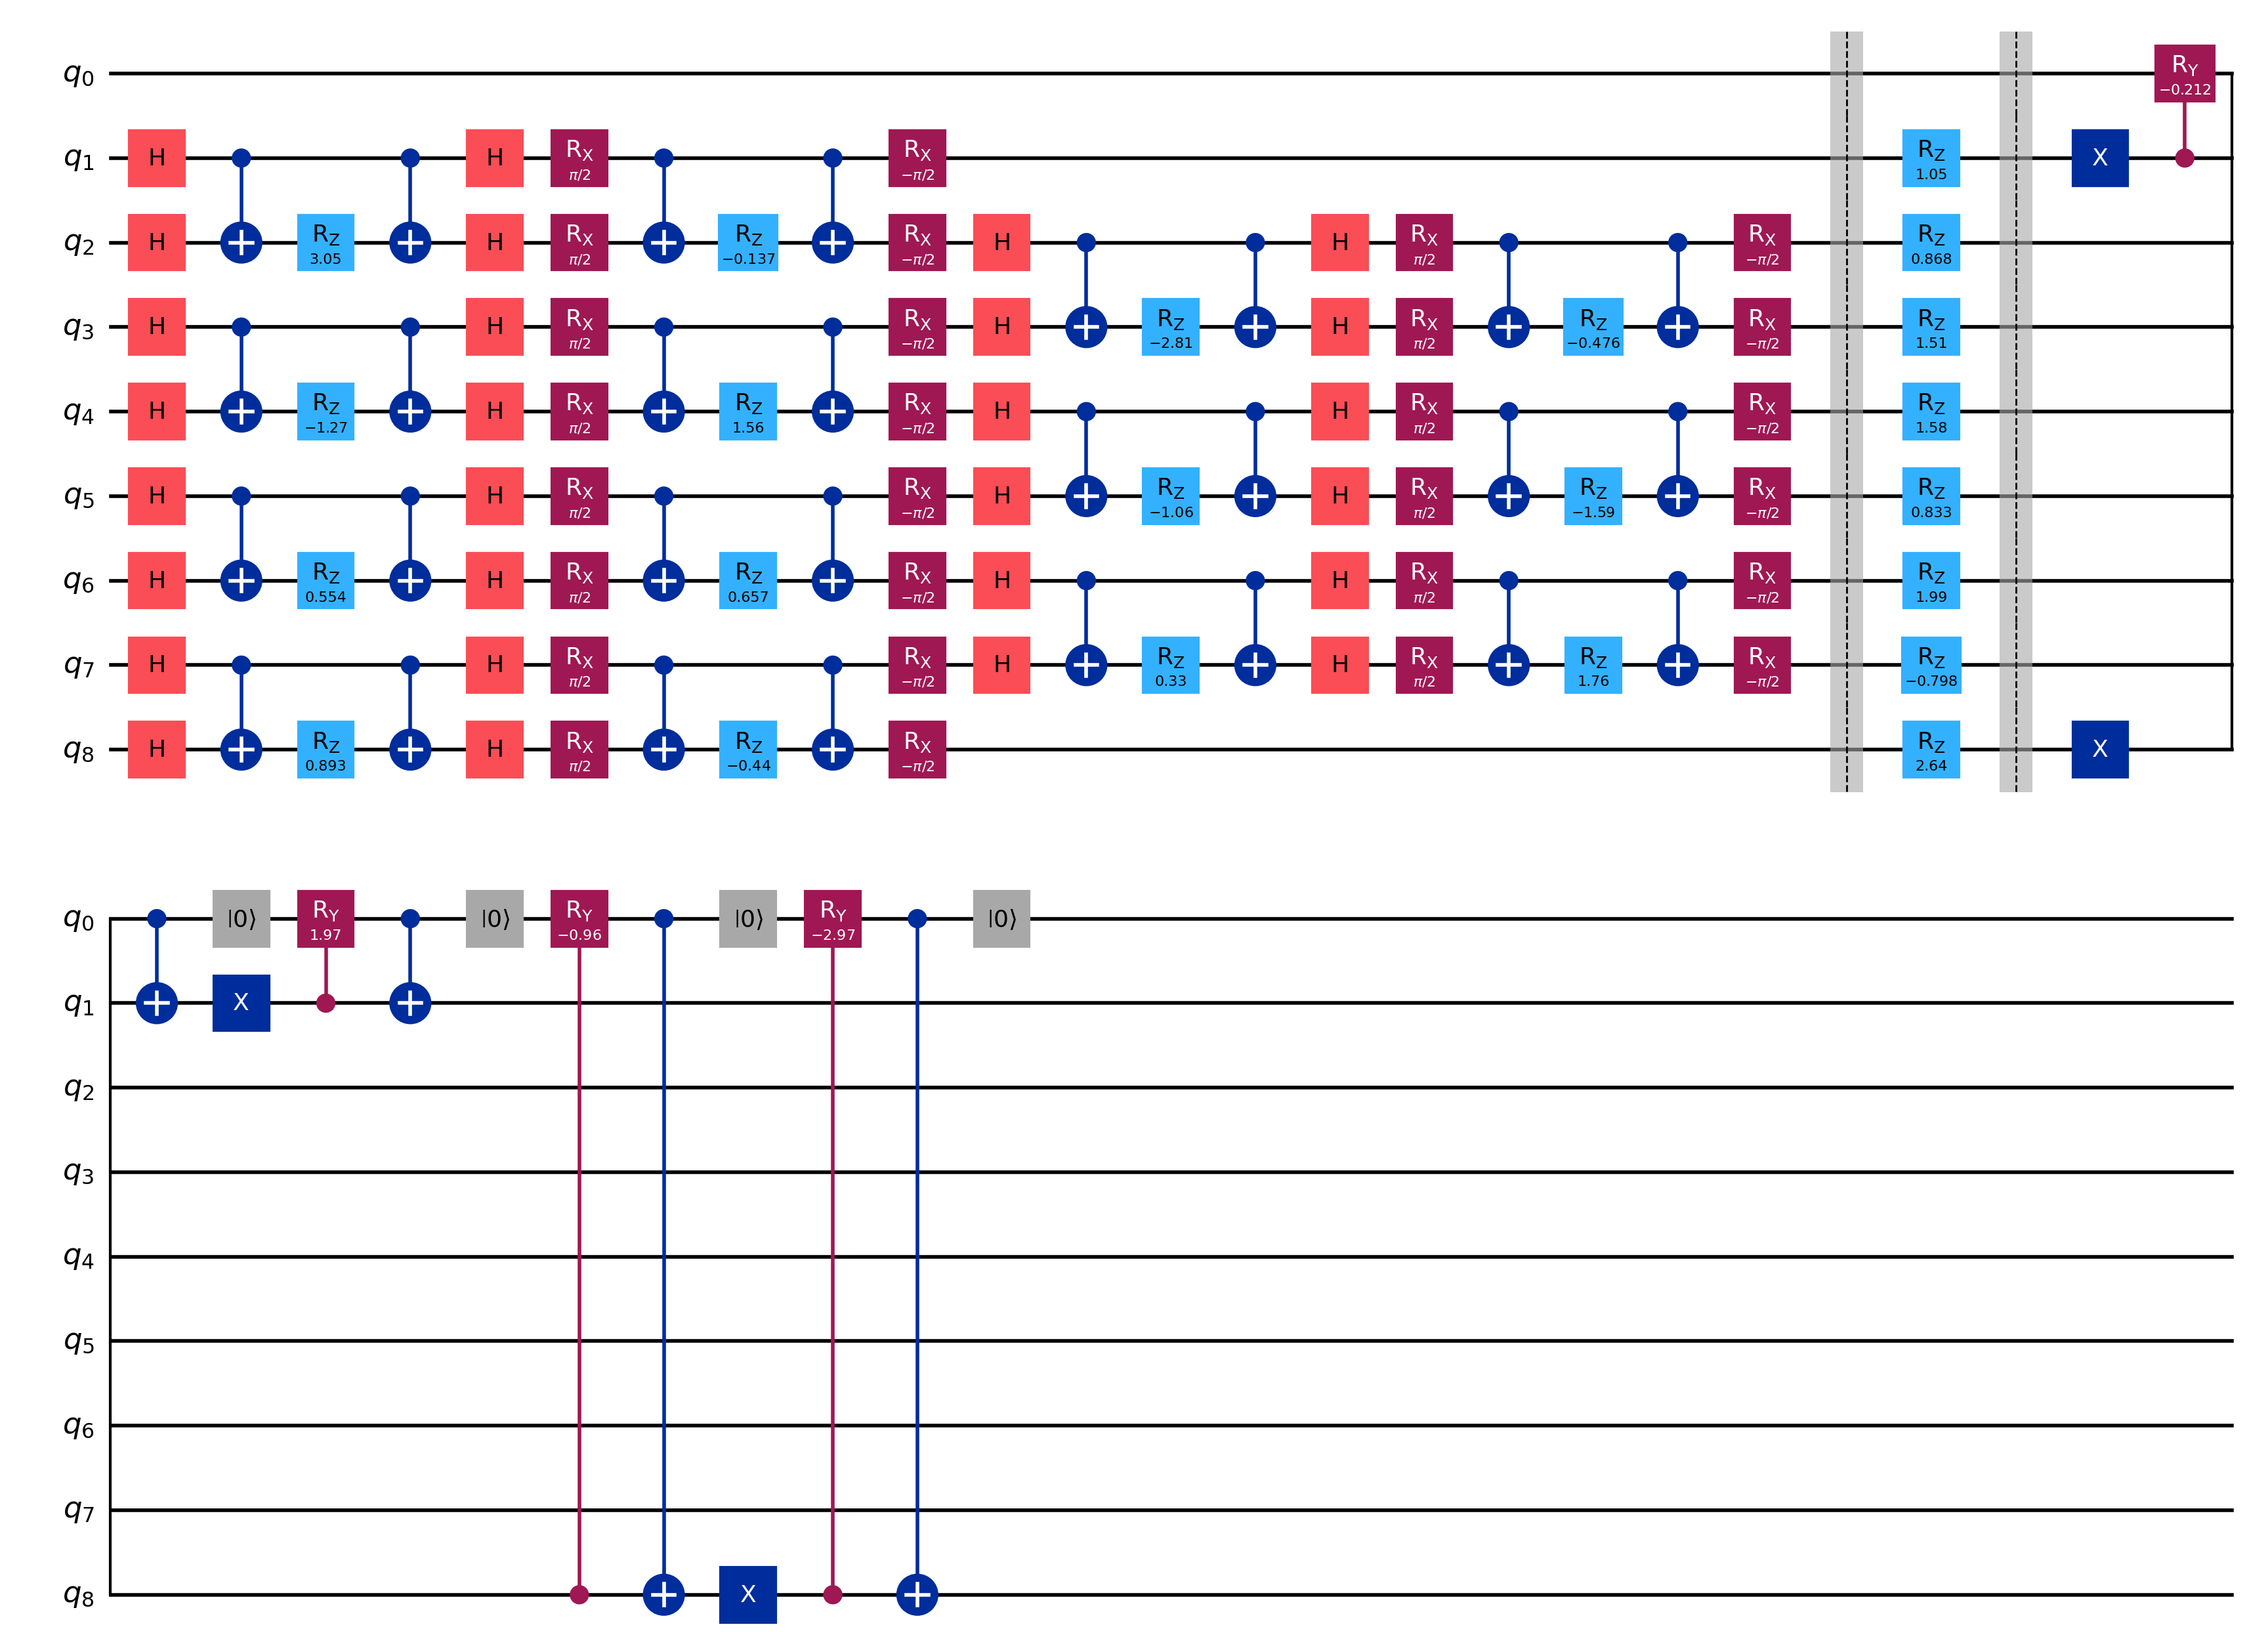

In [4]:
# VQA circuit.
from qiskit import QuantumCircuit, transpile

# Pauli matrices and identity (sparse format)
I = csr_matrix([[1, 0], [0, 1]], dtype=complex)
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=complex)
sigma_y = csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=complex)

# The variational circuit is just the trotter circuit for the TFIM.
n_qubits = 8
def anstaz_circuit(angles_lst, number_of_layers):  

    anstaz_circuit = QuantumCircuit(n_qubits + 1)
    for l in range(number_of_layers):
        angle_count = 0
        # Even bonds.
        for q in range(0, n_qubits-1, 2):
            q = q + 1
            # XX operator.
            anstaz_circuit.h(q)
            anstaz_circuit.h(q+1)
            anstaz_circuit.cx(q, q+1)
            anstaz_circuit.rz(angles_lst[l][angle_count], q+1)
            angle_count += 1
            anstaz_circuit.cx(q, q+1)
            anstaz_circuit.h(q)
            anstaz_circuit.h(q+1)
            # YY operator.
            """ 
                The YY interaction can be implemented using the following:
                Y = Rx(pi/2) * Z * Rx(-pi/2)

            """
            # Implementing the Hy matrix using the decomposition.
            anstaz_circuit.rx(np.pi/2, q)
            anstaz_circuit.rx(np.pi/2, q+1)
            # Standard ZZ operator circuit.
            anstaz_circuit.cx(q, q+1)
            anstaz_circuit.rz(angles_lst[l][angle_count], q+1)
            angle_count += 1
            anstaz_circuit.cx(q, q+1)
            # Implementing the Hy matrix using the decomposition.
            anstaz_circuit.rx(-np.pi/2, q)
            anstaz_circuit.rx(-np.pi/2, q+1)

        # Odd bonds.    
        for q in range(1, n_qubits-1, 2):
            q = q + 1
            # XX operator.
            anstaz_circuit.h(q)
            anstaz_circuit.h(q+1)
            anstaz_circuit.cx(q, q+1)
            anstaz_circuit.rz(angles_lst[l][angle_count], q+1)
            angle_count += 1
            anstaz_circuit.cx(q, q+1)
            anstaz_circuit.h(q)
            anstaz_circuit.h(q+1)
            # YY operator.
            """ 
                The YY interaction can be implemented using the following:
                Y = Rx(pi/2) * Z * Rx(-pi/2)

            """
            # Implementing the Hy matrix using the decomposition.
            anstaz_circuit.rx(np.pi/2, q)
            anstaz_circuit.rx(np.pi/2, q+1)
            # Standard ZZ operator circuit.
            anstaz_circuit.cx(q, q+1)
            anstaz_circuit.rz(angles_lst[l][angle_count], q+1)
            angle_count += 1
            anstaz_circuit.cx(q, q+1)
            # Implementing the Hy matrix using the decomposition.
            anstaz_circuit.rx(-np.pi/2, q)
            anstaz_circuit.rx(-np.pi/2, q+1)
        
        anstaz_circuit.barrier()
        # Single qubit gates. 
        for q in range(1, n_qubits+1):      
            anstaz_circuit.rz(angles_lst[l][angle_count], q)
            angle_count += 1     
    
        anstaz_circuit.barrier()
        # Jump operators.
        # L_1.
        anstaz_circuit.x(1)
        anstaz_circuit.cry(angles_lst[l][angle_count], 1, 0)
        angle_count += 1
        anstaz_circuit.cx(0,1)
        anstaz_circuit.x(1)
        anstaz_circuit.reset(0)
        # L_2.
        anstaz_circuit.cry(angles_lst[l][angle_count], 1, 0)
        angle_count += 1
        anstaz_circuit.cx(0,1)
        anstaz_circuit.reset(0)
        # L_3.
        anstaz_circuit.x(n_qubits)
        anstaz_circuit.cry(angles_lst[l][angle_count], n_qubits, 0)
        angle_count += 1
        anstaz_circuit.cx(0,n_qubits)
        anstaz_circuit.x(n_qubits)
        anstaz_circuit.reset(0)
        # L_4.
        anstaz_circuit.cry(angles_lst[l][angle_count], n_qubits, 0)
        angle_count += 1
        anstaz_circuit.cx(0,n_qubits)
        anstaz_circuit.reset(0)            

    return anstaz_circuit   

number_of_parameters_per_layer = 3 * n_qubits + 2
number_of_layer = 1
parameters_lst = [[np.random.uniform(-np.pi, np.pi) for i in range(number_of_parameters_per_layer)] for j in range(number_of_layer)]
#print("Total number of parameters: ", len(np.array(parameters_lst).flatten()))
anstaz_circuit(parameters_lst, number_of_layer).draw("mpl", scale = 2)  

# Lindblad equation

In [5]:
# Parameters for the Hamiltonian and jump operators.
J = 1.5
h = 1.0
gamma_1 = 1.0
gamma_2 = 0.6
gamma_3 = 1.0
gamma_4 = 0.3

chain_length = n_qubits

""" 
Here we build the Hamiltonian for the homogeneous transverse field Ising chain with chain length n:

H = J * ∑_{m=1}^{n-1} (X_m X_{m+1} + Y_m Y_{m+1}) + h * ∑_{m=1}^{n} Z_m.

The Lindblad operators are:
L_1 = 1/2*√(gamma_1) * (X_1 - i Y_1) ⊗ I ⊗ ... ⊗ I,
L_2 = 1/2*√(gamma_2) * (X_1 + i Y_1) ⊗ I ⊗ ... ⊗ I,
L_3 = I ⊗ ... ⊗ I ⊗ 1/2*√(gamma_3) * (X_n - i Y_n),
L_4 = I ⊗ ... ⊗ I ⊗ 1/2*√(gamma_4) * (X_n + i Y_n).

"""

def build_hamiltonian(n):

    # Initialize the Hamiltonian as a sparse matrix
    dim = 2 ** n
    H = csr_matrix((dim, dim), dtype=complex)

    # Build the interaction terms without periodic boundary conditions
    for m in range(n - 1):

        # XX interaction.
        # Operators for the interaction terms
        X_ops = [I] * n
        Y_ops = [I] * n
        X_ops[m] = sigma_x
        X_ops[m + 1] = sigma_x
        
        # YY interaction.
        Y_ops[m] = sigma_y
        Y_ops[m + 1] = sigma_y

        # Tensor products for X_m X_{m+1} and Y_m Y_{m+1}
        X_term = X_ops[0]
        Y_term = Y_ops[0]
        for op in X_ops[1:]:
            X_term = kron(X_term, op)
        for op in Y_ops[1:]:
            Y_term = kron(Y_term, op)

        H += J * (X_term + Y_term)

    # Z terms.
    for m in range(n):

        Z_ops = [I] * n
        Z_ops[m] = sigma_z
        # Tensor product for Z_m
        Z_term = Z_ops[0]
        for op in Z_ops[1:]:
            Z_term = kron(Z_term, op)
        H += h * Z_term

    return H

# Jump operators
def build_jump_operators(n):

    # L_1 acts on spin 1
    L_1_ops = [0.5*np.sqrt(gamma_1) * (sigma_x - 1j * sigma_y)] + [I] * (n - 1)
    L_1 = L_1_ops[0]
    for op in L_1_ops[1:]:
        L_1 = kron(L_1, op)
    
    # L_2 acts on spin 1
    L_2_ops = [0.5*np.sqrt(gamma_2) * (sigma_x + 1j * sigma_y)] + [I] * (n - 1)
    L_2 = L_2_ops[0]
    for op in L_2_ops[1:]:
        L_2 = kron(L_2, op)

    # L_3 acts on spin n
    L_3_ops = [I] * (n - 1) + [0.5*np.sqrt(gamma_3) * (sigma_x - 1j * sigma_y)]
    L_3 = L_3_ops[0]
    for op in L_3_ops[1:]:
        L_3 = kron(L_3, op)
    
    # L_4 qcts on spin n.
    L_4_ops = [I] * (n - 1) + [0.5*np.sqrt(gamma_4) * (sigma_x + 1j * sigma_y)]
    L_4 = L_4_ops[0]
    for op in L_4_ops[1:]:
        L_4 = kron(L_4, op)

    return L_1, L_2, L_3, L_4

# Lindblad equation
def lindblad_equation(rho):
    
    rho = csr_matrix(rho)

    # Build Hamiltonian and jump operators
    H = build_hamiltonian(chain_length)
    L_1, L_2, L_3, L_4 = build_jump_operators(chain_length)

    # Commutator: -i [H, rho]
    commutator = -1j * (H @ rho - rho @ H)

    # Lindblad dissipator terms
    lindblad_1 = 2 * L_1 @ rho @ L_1.getH() - (L_1.getH() @ L_1 @ rho + rho @ L_1.getH() @ L_1)
    lindblad_2 = 2 * L_2 @ rho @ L_2.getH() - (L_2.getH() @ L_2 @ rho + rho @ L_2.getH() @ L_2)
    lindblad_3 = 2 * L_3 @ rho @ L_3.getH() - (L_3.getH() @ L_3 @ rho + rho @ L_3.getH() @ L_3)
    lindblad_4 = 2 * L_4 @ rho @ L_4.getH() - (L_4.getH() @ L_4 @ rho + rho @ L_4.getH() @ L_4)    

    d_rho_dt = commutator + lindblad_1 + lindblad_2 + lindblad_3 + lindblad_4
    return d_rho_dt

# Cost function
def cost_function(rho):
    L_rho = lindblad_equation(rho)
    return np.real(np.trace(L_rho.conj().T @ L_rho.toarray()))

# Density matrix noisy and noiseless simulation

In [6]:
# def return_density_matrix(quantum_circuit):

#      quantum_circuit.save_density_matrix()  # Save the density matrix

#      # Step 2: Simulate the circuit
#      simulator = AerSimulator()  # Aer simulator supports reset gates
#      quantum_circuit = transpile(quantum_circuit, simulator)
#      result = simulator.run(quantum_circuit).result()
#      # Step 3: Extract the density matrix
#      rho_full = DensityMatrix(result.data()["density_matrix"])

#      # Step 4: Compute the reduced density matrix for the second qubit
#      rho_1 = partial_trace(rho_full, [0])  # Trace out qubit 0
#      rho_1_matrix = rho_1.data

#      return rho_1_matrix

L = n_qubits
from qiskit_aer.noise import (
    NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error,
)
"""
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05
 
# QuantumError objects
error_reset = pauli_error([("X", p_reset), ("I", 1 - p_reset)])
error_meas = pauli_error([("X",p_meas), ("I", 1 - p_meas)])
error_gate1 = pauli_error([("X",p_gate1), ("I", 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
 
# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

noise_model = noise_bit_flip
 
# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ["u1", "u2", "u3"])
"""

# T1 and T2 values for qubits 0-3
T1s = np.random.normal(100e3, 10e3, L+1)  # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(200e3, 10e3, L+1)  # Sampled from normal distribution mean 50 microsec
 
# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(L+1)])
 
# Instruction times (in nanoseconds)
time_u1 = 0  # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100  # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000  # 1 microsecond
 
# QuantumError objects
errors_reset = [
    thermal_relaxation_error(t1, t2, time_reset) for t1, t2 in zip(T1s, T2s)
]
errors_measure = [
    thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)
]
errors_u1 = [
    thermal_relaxation_error(t1, t2, time_u1) for t1, t2 in zip(T1s, T2s)
]
errors_u2 = [
    thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)
]
errors_u3 = [
    thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)
]
errors_cx = [
    [
        thermal_relaxation_error(t1a, t2a, time_cx).expand(
            thermal_relaxation_error(t1b, t2b, time_cx)
        )
        for t1a, t2a in zip(T1s, T2s)
    ]
    for t1b, t2b in zip(T1s, T2s)
]
 
# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(L+1):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(L+1):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
 
noise_model = noise_thermal
print(noise_model)
def return_density_matrix(quantum_circuit, noise_model=None):

     quantum_circuit.save_density_matrix()  # Save the density matrix

     # Step 2: Simulate the circuit
     simulator = AerSimulator(noise_model=noise_thermal)  # Aer simulator supports reset gates
     quantum_circuit = transpile(quantum_circuit, simulator)
     result = simulator.run(quantum_circuit).result()
     # Step 3: Extract the density matrix
     rho_full = DensityMatrix(result.data()["density_matrix"])

     # Step 4: Compute the reduced density matrix for the second qubit
     rho_1 = partial_trace(rho_full, [0])  # Trace out qubit 0
     rho_1_matrix = rho_1.data

     return rho_1_matrix

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['reset', 'cx', 'measure', 'u2', 'u3']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('reset', (7,)), ('reset', (8,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,)), ('measure', (6,)), ('measure', (7,)), ('measure', (8,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u2', (4,)), ('u2', (5,)), ('u2', (6,)), ('u2', (7,)), ('u2', (8,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('u3', (4,)), ('u3', (5,)), ('u3', (6,)), ('u3', (7,)), ('u3', (8,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (0, 4)), ('cx', (0, 5)), ('cx', (0, 6)), ('cx', (0, 7)), ('cx', (0, 8)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (1, 

# Parameter shift rule for gradient descent

In [7]:
import numpy as np

number_of_parameters_per_layer = 3 * n_qubits + 2

def update_angles(current_angles_lst, number_of_layers, learning_rate):
    """
    Perform parameter-shift updates on angles for a VQA circuit.
    
    Parameters:
        current_angles_lst (list of lists): Current angles for each layer (shape: [number_of_layers, 8]).
        number_of_layers (int): Number of layers in the VQA circuit.
        learning_rate (float): Learning rate for gradient descent.

    Returns:
        updated_angles (list of lists): Updated angles after applying parameter-shift rule.
    """
    # Initialize the updated angles as a copy of the current angles
    updated_angles = np.array(current_angles_lst, copy=True)
    
    # Iterate over each layer and each parameter
    for i in range(number_of_layers):
        for j in range(number_of_parameters_per_layer):
            # Create shifted angle sets for parameter (i, j)
            angles_plus = np.array(current_angles_lst, copy=True)
            angles_minus = np.array(current_angles_lst, copy=True)
            
            # Shift the specific parameter
            angles_plus[i][j] += np.pi / 2
            angles_minus[i][j] -= np.pi / 2
            
            # Compute the cost for shifted parameters
            cost_plus = cost_function(return_density_matrix(anstaz_circuit(angles_plus, number_of_layers)))
            cost_minus = cost_function(return_density_matrix(anstaz_circuit(angles_minus, number_of_layers)))
            
            # Compute the gradient for this parameter
            gradient = (cost_plus - cost_minus) / 2
            
            # Update the parameter using gradient descent
            updated_angles[i][j] -= learning_rate * gradient
    
    return updated_angles

# Variational algorithm

## Gradient descent

In [8]:
import numpy as np

# Parameters
initial_learning_rate = 0.1
number_of_layers = 4
max_iterations = 10
tolerance_for_convergence = 1e-2

number_of_parameters_per_layer = 3 * n_qubits + 2

# We will initialize the initial angles as the trotter angles.
trotter_step = 0.1
initial_angles_lst = [[trotter_step*2 for _ in range(number_of_parameters_per_layer)] for _ in range(number_of_layers)]

# np.random.seed(355113)
# initial_angles_lst = [[np.random.uniform(-np.pi, np.pi) for _ in range(number_of_parameters_per_layer)] for _ in range(number_of_layers)]

angles_lst = initial_angles_lst.copy()
best_angles_lst = initial_angles_lst.copy()

# Initialize optimization variables
number_of_iteration = 0
best_cost = float("inf")
best_iteration = 0
cost_function_values_lst = []

# Print initial state
print("Initial angles: ", initial_angles_lst)

# Optimization loop
while number_of_iteration < max_iterations:
    # Generate variational circuit and compute cost
    vqa_circuit = anstaz_circuit(angles_lst, number_of_layers)
    rho = return_density_matrix(vqa_circuit)
    cost_value = cost_function(rho)

    # Record and display the cost
    cost_function_values_lst.append(cost_value)
    print(f"Iteration {number_of_iteration}: Cost value = {cost_value:.6f}")

    # Update best solution
    if cost_value < best_cost:
        best_cost = cost_value
        best_angles_lst = angles_lst.copy()
        best_iteration = number_of_iteration

    # Check for convergence
    if cost_value < tolerance_for_convergence:
        print("Optimization has converged.")
        print(f"Best cost value: {best_cost:.6f}")
        print("Best angles:", best_angles_lst)
        break

    # Adjust learning rate
    learning_rate = initial_learning_rate / (number_of_iteration + 1)

    # Update angles using the parameter-shift rule
    angles_lst = update_angles(angles_lst, number_of_layers, learning_rate)

    # Increment iteration counter
    number_of_iteration += 1

# Post-optimization summary
if number_of_iteration == max_iterations:
    print("The optimization did not converge within the maximum iterations.")
print(f"Best cost value: {best_cost:.6f}")
print("Best angles:", best_angles_lst)

Initial angles:  [[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]]
Iteration 0: Cost value = 9.480471
Iteration 1: Cost value = 10.120258
Iteration 2: Cost value = 10.450278
Iteration 3: Cost value = 10.579758


KeyboardInterrupt: 

## Adam optimizer

In [ ]:
# import numpy as np

# # Adam optimizer parameters
# beta1 = 0.9
# beta2 = 0.999
# epsilon = 1e-8
# initial_learning_rate = 0.1
# max_iterations = 10
# tolerance_for_convergence = 1e-2

# # Initialize Adam parameters
# number_of_layers = 4
# number_of_parameters_per_layer = 3 * n_qubits + 2
# m = np.zeros((number_of_layers, number_of_parameters_per_layer))  # First moment
# v = np.zeros((number_of_layers, number_of_parameters_per_layer))  # Second moment
# t = 0  # Time step

# # Initialize angles with trotter angles
# angles_lst = [[trotter_step*2 for _ in range(number_of_parameters_per_layer)] for _ in range(number_of_layers)]
# best_angles_lst = angles_lst.copy()
# best_cost = float('inf')
# cost_function_values_lst = []

# # Optimization loop
# while t < max_iterations:
#      # Generate circuit and compute cost
#      vqa_circuit = anstaz_circuit(angles_lst, number_of_layers)
#      rho = return_density_matrix(vqa_circuit)
#      cost_value = cost_function(rho)
     
#      cost_function_values_lst.append(cost_value)
#      print(f"Iteration {t}: Cost value = {cost_value:.6f}")
     
#      # Update best solution
#      if cost_value < best_cost:
#           best_cost = cost_value
#           best_angles_lst = angles_lst.copy()
     
#      # Check convergence
#      if cost_value < tolerance_for_convergence:
#           print("Optimization converged!")
#           break
          
#      # Compute gradients using parameter-shift rule
#      gradients = np.zeros((number_of_layers, number_of_parameters_per_layer))
#      for i in range(number_of_layers):
#           for j in range(number_of_parameters_per_layer):
#                angles_plus = np.array(angles_lst, copy=True)
#                angles_minus = np.array(angles_lst, copy=True)
               
#                angles_plus[i][j] += np.pi / 2
#                angles_minus[i][j] -= np.pi / 2
               
#                cost_plus = cost_function(return_density_matrix(anstaz_circuit(angles_plus, number_of_layers)))
#                cost_minus = cost_function(return_density_matrix(anstaz_circuit(angles_minus, number_of_layers)))
               
#                gradients[i][j] = (cost_plus - cost_minus) / 2
     
#      # Update moments
#      t += 1
#      m = beta1 * m + (1 - beta1) * gradients
#      v = beta2 * v + (1 - beta2) * np.square(gradients)
     
#      # Bias correction
#      m_hat = m / (1 - beta1**t)
#      v_hat = v / (1 - beta2**t)
     
#      # Update parameters
#      lr = initial_learning_rate * np.sqrt(1 - beta2**t) / (1 - beta1**t)
#      angles_lst = np.array(angles_lst) - lr * m_hat / (np.sqrt(v_hat) + epsilon)
#      angles_lst = angles_lst.tolist()

# print(f"Best cost value: {best_cost:.6f}")

In [9]:
#np.save("rho_SS_4.npy", rho)
#np.save("cost_function_values_noisy_"+str(number_of_layers)+"_4.npy", cost_function_values_lst)

# Plot

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(cost_function_values_lst)), cost_function_values_lst, marker="o", linestyle='-', color="rebeccapurple", linewidth=2, markersize=8, label="Cost Function")
plt.xlabel("Number of Iterations", fontsize=20, labelpad=10)
plt.ylabel("Cost Function Value", fontsize=20, labelpad=10)
plt.title("Cost Function vs. Number of Iterations", fontsize=18, pad=15)
#plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color="r", linestyle="--")
# Get current axis
ax = plt.gca()
# Make axis lines thicker
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
# Make ticks longer
ax.tick_params(axis='both', which='major', length=10)
plt.tight_layout()
#plt.axhline(y=0.8, color="r", linestyle="--")
plt.show()

In [11]:
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix, kron
from numpy import trace

n = n_qubits
I = csr_matrix([[1, 0], [0, 1]], dtype=complex)
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=complex)
sigma_y = csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=complex)

def spin_current_expectation_value(rho_steady_state, m):

     #spin_current_m = np.zeros((2 ** n, 2 ** n), dtype=complex)

     X_ops = [I] * n
     Y_ops = [I] * n
     X_ops[m] = sigma_x
     Y_ops[m + 1] = sigma_y

     X_term = X_ops[0]
     for op in X_ops[1:]:
          X_term = kron(X_term, op)
     Y_term = Y_ops[0]          
     for op in Y_ops[1:]:
          Y_term = kron(Y_term, op)

     X_ops = [I] * n
     Y_ops = [I] * n
     X_ops[m + 1] = sigma_x
     Y_ops[m] = sigma_y

     X_term = X_ops[0]
     for op in X_ops[1:]:
          X_term = kron(X_term, op)
     Y_term = Y_ops[0]          
     for op in Y_ops[1:]:
          Y_term = kron(Y_term, op)

     spin_current_m = (X_term @ Y_term) - (Y_term @ X_term)

     return np.real(np.trace(rho_steady_state @ spin_current_m))

def average_spin_current_expectation_value(rho_steady_state):

     average_spin_current = 0
     for i in range(n - 1):
          average_spin_current += spin_current_expectation_value(rho_steady_state, i)

     return average_spin_current / (n - 1)      

In [ ]:
print("Average spin current: ", average_spin_current_expectation_value(rho))